In [1]:
%matplotlib inline
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Create the graph
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990', '2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)

    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('1995', ypos, 'Training')
    ax.text('2002-3', ypos, 'Validation')

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend(): 
        axes[0].get_legend().remove()

# 18.1 9/11 사태로 인한 미국 항공기 여행 여파

In [3]:
bts = pd.read_csv('Sept11Travel.csv')
bts = bts.rename(columns = {'Month-Year':'Day'})

In [4]:
p_bts = bts.iloc[0:120]
p_bts # 9/11 전 데이터 - 학습데이터로 이용

,Day,AirRPM,RailPM,VMT_billions
0,Jan-90,35153577,454115779,163.28
1,Feb-90,32965187,435086002,153.25
2,Mar-90,39993913,568289732,178.42
3,Apr-90,37981886,568101697,178.68
4,May-90,38419672,539628385,188.88
...,...,...,...,...
115,Aug-99,63752132,528001216,242.57
116,Sep-99,53733696,393137094,225.30
117,Oct-99,57407208,425897553,234.66
118,Nov-99,53866781,421595015,222.83


In [5]:
p_bts['Day']=pd.to_datetime(p_bts.Day, format='%b-%y')
p_bts

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10964\398678094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_bts['Day']=pd.to_datetime(p_bts.Day, format='%b-%y')


,Day,AirRPM,RailPM,VMT_billions
0,1990-01-01,35153577,454115779,163.28
1,1990-02-01,32965187,435086002,153.25
2,1990-03-01,39993913,568289732,178.42
3,1990-04-01,37981886,568101697,178.68
4,1990-05-01,38419672,539628385,188.88
...,...,...,...,...
115,1999-08-01,63752132,528001216,242.57
116,1999-09-01,53733696,393137094,225.30
117,1999-10-01,57407208,425897553,234.66
118,1999-11-01,53866781,421595015,222.83


### a

64397523
29672427


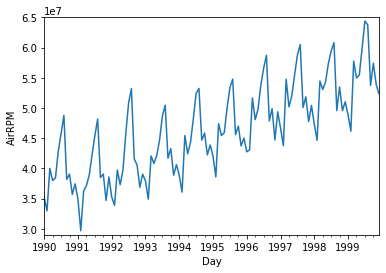

In [6]:
## 항공기 시계열 데이터

# convert dataframe column to series (name is used to label the data)
pbts_Airrpm = pd.Series(p_bts.AirRPM.values, index=p_bts.Day, name='AirRPM')

# define the time series frequency
pbts_Airrpm.index = pd.DatetimeIndex(pbts_Airrpm.index, freq=pbts_Airrpm.index.inferred_freq)

# y 축 범위 조정을 위해 최댓값 및 최솟값 구하기
print(p_bts.AirRPM.max())
print(p_bts.AirRPM.min())

ax = pbts_Airrpm.plot()
ax.set_xlabel('Day')
ax.set_ylabel('AirRPM')
_ = ax.set_ylim(29000000, 65000000)

plt.show()

### b

추세는 증가하는 경향이나 감소하는 경향을 의미하는데 해당 그래프는 증가하는 추세가 있다고 본다

In [7]:
## 계절 변동이 제거된 항공기 시계열 그래프

##### 이중지수평활법

평활법은 크게 두가지로 구분했을 때 이동평균법과 단순지수평활법으로 나눌 수 있다. 

두 방법 모두 추세나 계절변동이 존재하지 않는 시계열에 적합한 방법이다.

위의 두 방법의 큰 차이는 예측을 위해 필요한 과거 데이터의 개수나 평균을 구할 때 사용하는 가중치 계산에서 차이를 보인다.


- 이동평균법 : 윈도우의 폭을 정하고 이에 따라 각 윈도우 내 연속된값들을 평균 구해 미래 값 예측 
- 단순지수평활법 : 과거 데이터들의 가중평균을 이용해 미래 값 예측
- 이중지수평활법 : 추세를 가진 시계열의 경우 적용 가능
- 홀트-윈터 지수평활법 : 추세와 계절변동이 모두 존재하는 시계열

# 18.2 이동평균법과 지수평활법의 관계

평활법을 적용할 때는 평활상수를 결정해야 하는데 평활상수는 최근 데이터에 부여할 가중치를 결정하는 역할을 한다.

이동평균법의 경우 윈도우의 폭w을, 지수평활법의 경우 평활상수(알파)를 결정해야 한다.
두 하이퍼 모수는 최근 정보가 과거의 정보에 비해 얼마나 중요하게 고려되는 지를 결정해주는 역할을 한다.
윈도우의 폭과 평활상수 사이에는 관계가 있는데 (윈도우의 폭)=2/(알파) - 1 인 경우 이동평균법과 지수평활법은 유사한 결과를 나타낸다. 

# 18.3 이동평균법을 사용한 예측

In [8]:
# data = {"월":"판매액", "Sept 98": "27", 
#         "Oct 98": "31", "Nov 98": "58", 
#        "Dec 98": "63", "Jan 98": "59"}

data = pd.DataFrame({"Month":["Sep 98", "Oct 98", "Nov 98", "Dec 98", "Jan 99"], # sept 하면 아래 format 이 적용이 안돼 sep으로 해줌
       "Price" : [27, 31, 58, 63, 59]})
data


,Month,Price
0,Sep 98,27
1,Oct 98,31
2,Nov 98,58
3,Dec 98,63
4,Jan 99,59


In [9]:
data.Month = pd.to_datetime(data.Month, format='%b %y')
data.Month

0   1998-09-01
1   1998-10-01
2   1998-11-01
3   1998-12-01
4   1999-01-01
Name: Month, dtype: datetime64[ns]

### a

In [10]:
# 예측 시에는 이전이동평균법이 사용되는데 이전이동평균법은 윈도우의 폭w를 정하고 이에 맞게 최근 w기간의 값들을 이용해 평균 구함

In [21]:
y = (27+31+58+63)/4
y

44.75

### b

In [22]:
ry = 59 
ry - y

14.25

# 18.4 홀트 - 윈터 지수평활법 최적화

### a

추세가 없다 ..?

In [13]:
# 시점 t 에서 t-1에서의 추세와 수준의 차이 값의 가중평균을 통해 구할 수 있음.
# 보기 3번과 4번은 어떤 의미로 해석해야 하는지 이해가 되지 않음

### b

보통 다양한 값들을 시도하여 그 중 검증 데이터의 예측 오류를 최소화하는 값을 정하는 방법이 사용되고 있다.
모델의 과적합이나 미래 데이터의 예측에 있어서 부정확한 결과를 도출할 수 있다. 
-> 지식이 없을 때는 통상적으로 0.1-0.2 사이의 값을 선택한다.

# 18.5 백화점 판매액 예측

In [14]:
departss = pd.read_csv('DepartmentStoreSales.csv')

In [15]:
departss.Quarter = pd.to_datetime(departss.Quarter, format='%d') # 분기니까 일로 변환하여 적용하는 것이 간단할 것이라 생각

In [16]:
# y 축 범위 조정을 위해 최댓값 및 최솟값 구하기
print(departss.Sales.max(),'  ', departss.Sales.min())

103337    48617


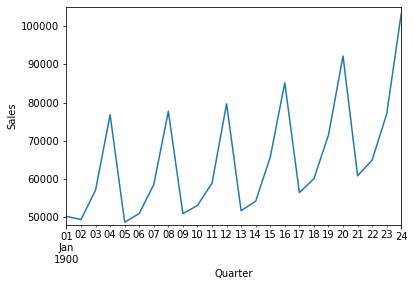

In [17]:
# convert dataframe column to series (name is used to label the data)
de_Sales = pd.Series(departss.Sales.values, index=departss.Quarter, name='Sales')

# define the time series frequency
de_Sales.index = pd.DatetimeIndex(de_Sales.index, freq=de_Sales.index.inferred_freq)

ax = de_Sales.plot()
ax.set_xlabel('Quarter')
ax.set_ylabel('Sales')
_ = ax.set_ylim(48000, 105000) 
plt.show()

증가하는 추세를 보임

변동성이 커지는 지는 잘 모르겠음

### a

이동평균법과 단순지수평활법은 추세가 존재하지 않는 시계열에 적합한 방법으로 사용되기 때문에 이를 제외한 것들은 적합하다고 생각한다.

### b

In [24]:
# partition the data
nValid = 4
nTrain = len(de_Sales) - nValid

train_ts = de_Sales[:nTrain]
valid_ts = de_Sales[nTrain:]


In [25]:
# run exponential smoothing with additive trend and additive seasonal
expSmooth = ExponentialSmoothing(train_ts, trend='additive', seasonal='additive', seasonal_periods=12, freq='MS')
expSmoothFit = expSmooth.fit()

fig, ax = plt.subplots(figsize=(9,4))
train_ts.plot(ax=ax, color='black', linewidth=0.5)
valid_ts.plot(ax=ax, color='black', linewidth=0.25)

expSmoothFit.fittedvalues.plot(ax=ax)
expSmoothFit.forecast(len(valid_ts)).plot(ax=ax, style='--', linewidth=2, color='C0')
singleGraphLayout(ax, [1300, 2550], train_ts, valid_ts)

plt.show()

ValueError: The given frequency argument is incompatible with the given index.

In [ ]:
# 왜이럴까 왜 에러가 날까...............

### c

큰 추세가 보이지 않아 지수평활법을 적용해도 괜찮을 것 같다

# 18.6 가전제품 선적량

In [26]:
As = pd.read_csv('ApplianceShipments.csv')

In [27]:
As['day']=pd.date_range("1985-1-1", "1989-12-31", freq=" Q-JAN")

In [40]:
As

,Quarter,Shipments,day
0,Q1-1985,4009,1985-01-31
1,Q2-1985,4321,1985-04-30
2,Q3-1985,4224,1985-07-31
3,Q4-1985,3944,1985-10-31
4,Q1-1986,4123,1986-01-31
5,Q2-1986,4522,1986-04-30
6,Q3-1986,4657,1986-07-31
7,Q4-1986,4030,1986-10-31
8,Q1-1987,4493,1987-01-31
9,Q2-1987,4806,1987-04-30


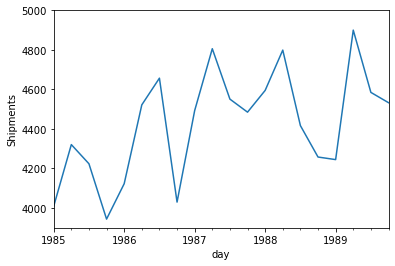

In [28]:
# convert dataframe column to series (name is used to label the data)
ass = pd.Series(As.Shipments.values, index=As.day, name='Shipments')

# define the time series frequency
ass.index = pd.DatetimeIndex(ass.index, freq=ass.index.inferred_freq)

ax = ass.plot()
ax.set_xlabel('day')
ax.set_ylabel('Shipments')
_ = ax.set_ylim(3900, 5000) 
plt.show()

### a

홀트 윈터 지수평활법

### b

In [29]:
nValid = 4
nTrain = len(ass) - nValid

train_ts = ass[:nTrain]
valid_ts = ass[nTrain:]

In [30]:
ma_trailing = train_ts.rolling(4).mean()
ma_trailing = pd.Series(ma_trailing[:-1].values, index=ma_trailing.index[1:])

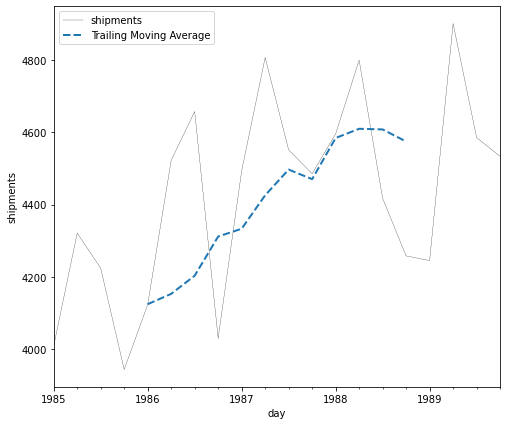

In [36]:
fig, ax = plt.subplots(figsize=(8, 7))
ax = ass.plot(ax=ax, color='black', linewidth=0.25)

ma_trailing.plot(ax=ax, style='--', linewidth=2)
ax.set_xlabel('day')
ax.set_ylabel('shipments')
ax.legend(['shipments', 'Trailing Moving Average'])

plt.show()

#### 1

증가하는 추세

#### 2

In [38]:
As.iloc[16:]

,Quarter,Shipments,day
16,Q1-1989,4245,1989-01-31
17,Q2-1989,4900,1989-04-30
18,Q3-1989,4585,1989-07-31
19,Q4-1989,4533,1989-10-31


In [39]:
sum_ship=4245+4900+4585+4533
sum_ship/4

4565.75

#### 3

#### 4

과대추정 ?

#### 5

윈도우가 시계열의 어떤 부분에 위치하는 지에 따라 유의해야 한다.

### c

# 18.7 샴푸 판매량 예측

홀트 윈터 지수평활법

추세와 변동 모두 있음

# 18.8 천연가스 판매량 

# 18.9 호주 와인의 판매량 